In [1]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split
import glob
from art.attacks.evasion import FastGradientMethod, SaliencyMapMethod, SpatialTransformation, FeatureAdversariesTensorFlowV2, ElasticNet,DeepFool,ProjectedGradientDescent,SimBA
from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_mnist

In [2]:
damaged = glob.glob('../preprocessed_data/training/damaged/*.*')
undamaged = glob.glob('../preprocessed_data/training/undamaged/*.*')
print(damaged[:5])
print(undamaged[:5])
data = []
labels = []

for i in damaged:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (128, 128, 3))
    image=np.array(image)/255.0
    data.append(image)
    labels.append(1)
for i in undamaged:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (128, 128, 3))
    image=np.array(image)/255.0
    data.append(image)
    labels.append(0)


test_damaged = glob.glob('../preprocessed_data/test/damaged/*.*')
test_undamaged = glob.glob('../preprocessed_data/test/undamaged/*.*')

for i in test_damaged:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (128, 128))
    image=np.array(image)/255.0
    data.append(image)
    labels.append(1)

for i in test_undamaged:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (128, 128))
    image=np.array(image)/255.0
    data.append(image)
    labels.append(0)

data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)


X_train, X_val, ytrain, yval = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, ytrain.shape)

['../preprocessed_data/training/damaged/0692.JPEG', '../preprocessed_data/training/damaged/0826.JPEG', '../preprocessed_data/training/damaged/0411.JPEG', '../preprocessed_data/training/damaged/0575.JPEG', '../preprocessed_data/training/damaged/0909.JPEG']
['../preprocessed_data/training/undamaged/0362.jpg', '../preprocessed_data/training/undamaged/0703.jpg', '../preprocessed_data/training/undamaged/0075.jpg', '../preprocessed_data/training/undamaged/0414.jpg', '../preprocessed_data/training/undamaged/0817.JPEG']
(2300, 128, 128, 3) (2300,)
(1840, 128, 128, 3) (1840,)


In [3]:
num_classes=2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=32, kernel_size=1, input_shape=(128,128,3)),
  tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=1, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_fn,
    train_step=train_step,
    nb_classes=num_classes,
    input_shape=(128, 128, 3)
)

y_train_one_hot= tf.keras.utils.to_categorical(ytrain)
y_val_one_hot= tf.keras.utils.to_categorical(yval)

history=classifier.fit(X_train , y_train_one_hot , batch_size=32, nb_epochs=100)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Sub: Dst tensor is not initialized. [Op:Sub]

In [ ]:
model.summary()

In [15]:
classifier.nb_classes

2

In [17]:
predictions = classifier.predict(X_train)
train_accuracy = 0
for i in range(len(predictions)):
    if np.argmax(predictions[i])==np.argmax(y_train_one_hot[i]):
        train_accuracy+=1
print("train accuarcy:", train_accuracy/len(ytrain)) 

predictions = classifier.predict(X_val)

undmg=0
undmT=0

for i in range(len(predictions)):
    if np.argmax(y_val_one_hot[i]) == 0:
        if np.argmax(predictions[i])==np.argmax(y_val_one_hot[i]):
            undmg+=1
        undmT+=1
print("val accuarcy after attack:", undmg/undmT)

[[9.0360550e-07 9.9999905e-01]
 [9.9999988e-01 9.3549730e-08]
 [1.5895896e-05 9.9998415e-01]
 [1.0000000e+00 1.4063416e-08]
 [6.8534013e-07 9.9999928e-01]
 [6.8457593e-05 9.9993157e-01]
 [9.9999893e-01 1.0973897e-06]
 [5.0744757e-06 9.9999487e-01]
 [6.8362606e-05 9.9993157e-01]
 [2.1916843e-05 9.9997807e-01]] 1 1
train accuarcy: 1.0
val accuarcy after attack: 0.7725321888412017


In [36]:
attack = FastGradientMethod(classifier, eps=0.2)
x_val_attack = attack.generate(x=X_val)
predictions = classifier.predict(x_val_attack)

undmg=0
undmT=0

for i in range(len(predictions)):
    if np.argmax(y_val_one_hot[i]) == 0:
        if np.argmax(predictions[i])==np.argmax(y_val_one_hot[i]):
            undmg+=1
        undmT+=1
        
print("val accuarcy after attack:", undmg/undmT)

val accuarcy after attack: 0.2317596566523605


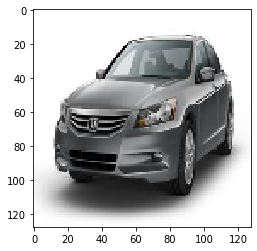

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


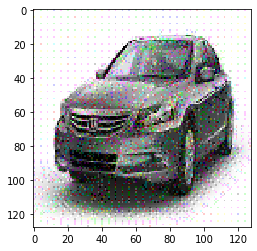

In [37]:
from matplotlib import pyplot as plt
plt.imshow(X_val[-10], interpolation='nearest')
plt.show()

plt.imshow(x_val_attack[-10], interpolation='nearest')
plt.show()


In [38]:
attack = DeepFool(classifier, epsilon=0.2)
x_val_attack = attack.generate(x=X_val)
predictions = classifier.predict(x_val_attack)

undmg=0
undmT=0

for i in range(len(predictions)):
    if np.argmax(y_val_one_hot[i]) == 0:
        if np.argmax(predictions[i])==np.argmax(y_val_one_hot[i]):
            undmg+=1
        undmT+=1
        
print("val accuarcy after attack:", undmg/undmT)


[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,

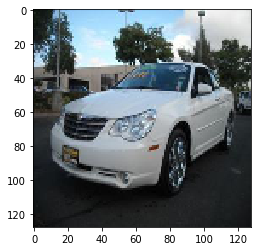

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


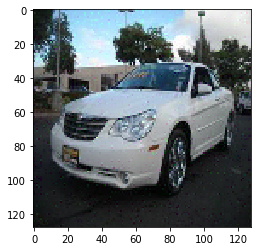

In [41]:
from matplotlib import pyplot as plt
plt.imshow(X_val[3], interpolation='nearest')
plt.show()

plt.imshow(x_val_attack[3], interpolation='nearest')
plt.show()


In [42]:
attack = SpatialTransformation(classifier, max_translation=10)
x_val_attack = attack.generate(x=X_val, y=y_val_one_hot)
predictions = classifier.predict(x_val_attack)
undmg=0
undmT=0
for i in range(len(predictions)):
    if np.argmax(y_val_one_hot[i]) == 0:
        if np.argmax(predictions[i])==np.argmax(y_val_one_hot[i]):
            undmg+=1
        undmT+=1
        
print("val accuarcy after attack:", undmg/undmT)


[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

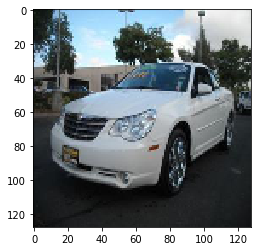

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


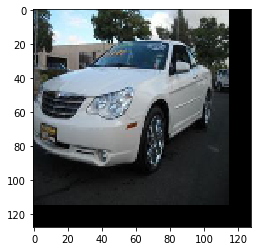

In [44]:
from matplotlib import pyplot as plt
plt.imshow(X_val[3], interpolation='nearest')
plt.show()

plt.imshow(x_val_attack[3], interpolation='nearest')
plt.show()
